In [75]:
import numpy as np
import matplotlib.pyplot as plt
import MEAutility as mu
from functools import reduce
import time
import sys

In [5]:
%run ZIAD_MEARotationFunctions.ipynb

In [9]:
# Load MEA data
folder_name = './ziad_mearec_templates/'
#mea_name = '2250000MEA2'
#mea_name = '100MEA75'
mea_name = '10000MEA30'

cell_id1 = 0
cell_id2 = 0

# Fields to calculate
sel_fields = [0, 1, 2, 3]
# str_fields = sys.argv[11]
# sel_fields = []
# for i in range(len(str_fields)):
#     sel_fields.append(int(str_fields[i]))

file_name = f'mag_templates_flattened_cell{cell_id1}_origin_{mea_name}.npy'

with open(folder_name + file_name, 'rb') as f:
    v = np.load(f)[:, :, :]
    bx = np.load(f)[:, :, :]
    by = np.load(f)[:, :, :]
    bz = np.load(f)[:, :, :]
    locs = np.load(f)
    rots = np.load(f)

v1 = v[0]
bx = bx[0]
by = by[0]
bz = bz[0]

B1 = np.zeros((np.shape(bx)[0], np.shape(bx)[1], 3))
B1[:, :, 0] = by
B1[:, :, 1] = bz
B1[:, :, 2] = bx

v2 = np.copy(v1)
bx = np.copy(bx)
by = np.copy(by)
bz = np.copy(bz)

B2 = np.copy(B1)

In [11]:
# Set rotation angles
thetas = np.linspace(0, 2*np.pi, 25)
#thetas = thetas[theta_idx1:theta_idx2]

# Replace pi/2 in thetas with pi/2-0.01 to avoid calculation erros
pi2_idx = np.where(np.isclose(thetas, np.pi/2))
if len(pi2_idx) > 0:
    pi2_idx = pi2_idx[0]
    thetas[pi2_idx] = np.pi/2 - 0.01
    print("Modified pi/2 value in thetas")

k = 5

# Get 2D y-z coordinates
mu.add_mea(mea_name + '.yaml')
mea = mu.return_mea(mea_name)
coords = mea.positions[:, 1:]
col_coords = np.unique(coords[:, 0])
row_coords = np.unique(coords[:, 1])
X, Y = np.meshgrid(col_coords, row_coords)

Modified pi/2 value in thetas
['1000000MEA2', '10000MEA30', '1000MEA1', '1000MEA1_Axial', '100MEA100', '100MEA1_Axial', '100MEA25', '100MEA50', '100MEA60_Axial', '100MEA75', '10201MEA30', '10MEA1', '1200000MEA1', '1500000MEA2', '2250000MEA2', '225MEA75', '250kMEA2', '4000000MEA1', '4000000MEA2', '40000MEA[1, 5]', '400MEA100', '400MEA50', '400MEA75', '400MEA[2, 10]', '4MEA1000', '500MEA1', '50MEA60', '50MEA60_Axial', '800MEA[2, 10]', 'Neuronexus-32', 'Neuropixels-128', 'Neuropixels-24', 'Neuropixels-384', 'Neuropixels-64', 'Neuroseeker-128', 'SqMEA-10-15', 'SqMEA-15-10', 'SqMEA-5-30', 'SqMEA-6-25', 'SqMEA-7-20', 'monotrode', 'testmea', 'tetrode', 'tetrode-mea-d', 'tetrode-mea-l', 'tetrode-mea-s']


In [38]:
def get_rotated_field(field, theta, coords, k):
    col_coords = np.unique(coords[:, 0])
    row_coords = np.unique(coords[:, 1])
    new_coords = rotate_matrix(theta, coords)

    # Find knn
    print("Finding k-nearest neighbors")
    k_nn, k_nn_dists = find_k_nn3(new_coords, coords, row_coords, col_coords, k)

    if len(np.shape(field)) == 2:
        return rotate_scalar_field(k_nn, k_nn_dists, field)
    else:
        return rotate_vector_field(k_nn, k_nn_dists, B2, theta)

In [57]:
thetas = np.linspace(0, 2*np.pi, 1)
print(thetas)

[0.]


In [90]:
# Generate averaged template
fields = [v1, B1]
avg_fields = np.zeros((4, np.shape(v1)[0], np.shape(v1)[1]))
thetas = np.linspace(0, 2*np.pi, 1)

for i, field in enumerate(fields):
    for j, theta in enumerate(thetas):
        
        rot_field = get_rotated_field(field, theta, coords, k=5)
        if len(np.shape(field)) == 2:
            avg_fields[i] += rot_field
        else:
            for k in range(3):
                avg_fields[i+k] += rot_field[:, :, k]

Finding k-nearest neighbors
Completed:  0 %
Completed:  10 %
Completed:  20 %
Completed:  30 %
Completed:  40 %
Completed:  50 %
Completed:  60 %
Completed:  70 %
Completed:  80 %
Completed:  90 %


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_61804/631223191.py:126: RuntimeWarning: divide by zero encountered in divide
  weights = 1/k_nn_dists
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_61804/631223191.py:127: RuntimeWarning: invalid value encountered in divide
  weights = weights/np.expand_dims(np.sum(weights, axis=1), axis=1)


Finding k-nearest neighbors
Completed:  0 %
Completed:  10 %
Completed:  20 %
Completed:  30 %
Completed:  40 %
Completed:  50 %
Completed:  60 %
Completed:  70 %
Completed:  80 %
Completed:  90 %


104.78926684159978
-423.53441357881974
1.018028434411139e-10
-1.0003029650184262e-10
1.1785274749114671e-11
-3.832965983252374e-11
4.427533098672036e-11
-7.145800638766461e-11


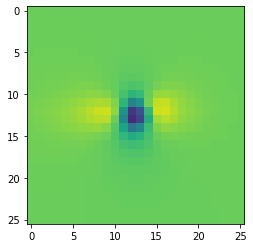

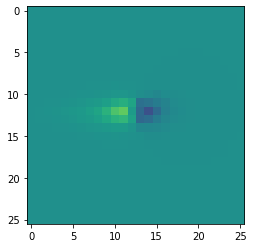

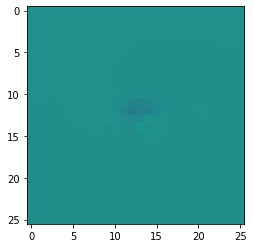

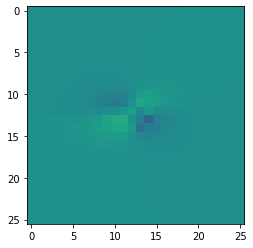

In [94]:
# Get coordinates within defined region (+/- 400 um in x and y) for plotting
idxs = reduce(np.intersect1d, (np.argwhere(coords[:, 0] >= -400), 
                                np.argwhere(coords[:, 0] <= 400), 
                                np.argwhere(coords[:, 1] >= -400),
                                np.argwhere(coords[:, 1] <= 400)))

rows = int(np.sqrt(len(idxs)))

for i, field in enumerate(avg_fields):
    field_pwrs = np.sum(field**2, axis=0)
    max_idx = np.argmax(field_pwrs)
    
    bounded_field = field[idxs]
    
    field_reshaped = np.reshape(bounded_field[:, max_idx], (rows, -1))
    print(np.max(field_reshaped))
    print(np.min(field_reshaped))
    
    if i == 0:
        vmin = -500
        vmax = 150
    else:
        vmin = -2e-10
        vmax = 2e-10
    
    plt.figure()
    plt.imshow(field_reshaped, vmin=vmin, vmax=vmax)

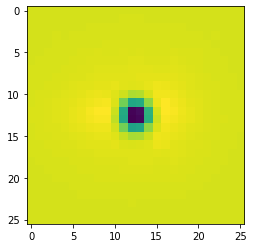

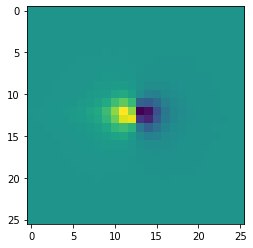

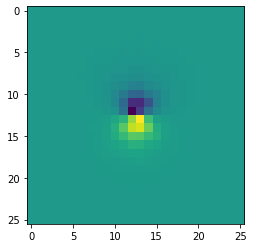

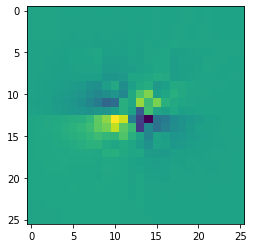

In [89]:
# Get coordinates within defined region (+/- 400 um in x and y) for plotting
idxs = reduce(np.intersect1d, (np.argwhere(coords[:, 0] >= -400), 
                                np.argwhere(coords[:, 0] <= 400), 
                                np.argwhere(coords[:, 1] >= -400),
                                np.argwhere(coords[:, 1] <= 400)))

rows = int(np.sqrt(len(idxs)))

for i, field in enumerate(avg_fields):
    field_pwrs = np.sum(field**2, axis=0)
    max_idx = np.argmax(field_pwrs)
    
    bounded_field = field[idxs]
    
    field_reshaped = np.reshape(bounded_field[:, max_idx], (rows, -1))
    
    plt.figure()
    plt.imshow(field_reshaped)

In [80]:
for i in range(len(coords[:, 1])):
    print(coords[i, 1])

-1485.0
-1455.0
-1425.0
-1395.0
-1365.0
-1335.0
-1305.0
-1275.0
-1245.0
-1215.0
-1185.0
-1155.0
-1125.0
-1095.0
-1065.0
-1035.0
-1005.0
-975.0
-945.0
-915.0
-885.0
-855.0
-825.0
-795.0
-765.0
-735.0
-705.0
-675.0
-645.0
-615.0
-585.0
-555.0
-525.0
-495.0
-465.0
-435.0
-405.0
-375.0
-345.0
-315.0
-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245.0
1275.0
1305.0
1335.0
1365.0
1395.0
1425.0
1455.0
1485.0
-1485.0
-1455.0
-1425.0
-1395.0
-1365.0
-1335.0
-1305.0
-1275.0
-1245.0
-1215.0
-1185.0
-1155.0
-1125.0
-1095.0
-1065.0
-1035.0
-1005.0
-975.0
-945.0
-915.0
-885.0
-855.0
-825.0
-795.0
-765.0
-735.0
-705.0
-675.0
-645.0
-615.0
-585.0
-555.0
-525.0
-495.0
-465.0
-435.0
-405.0
-375.0
-345.0
-315.0
-285.0
-255.0
-225.0
-195

-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245.0
1275.0
1305.0
1335.0
1365.0
1395.0
1425.0
1455.0
1485.0
-1485.0
-1455.0
-1425.0
-1395.0
-1365.0
-1335.0
-1305.0
-1275.0
-1245.0
-1215.0
-1185.0
-1155.0
-1125.0
-1095.0
-1065.0
-1035.0
-1005.0
-975.0
-945.0
-915.0
-885.0
-855.0
-825.0
-795.0
-765.0
-735.0
-705.0
-675.0
-645.0
-615.0
-585.0
-555.0
-525.0
-495.0
-465.0
-435.0
-405.0
-375.0
-345.0
-315.0
-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245.0
1275

-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245.0
1275.0
1305.0
1335.0
1365.0
1395.0
1425.0
1455.0
1485.0
-1485.0
-1455.0
-1425.0
-1395.0
-1365.0
-1335.0
-1305.0
-1275.0
-1245.0
-1215.0
-1185.0
-1155.0
-1125.0
-1095.0
-1065.0
-1035.0
-1005.0
-975.0
-945.0
-915.0
-885.0
-855.0
-825.0
-795.0
-765.0
-735.0
-705.0
-675.0
-645.0
-615.0
-585.0
-555.0
-525.0
-495.0
-465.0
-435.0
-405.0
-375.0
-345.0
-315.0
-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245

-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245.0
1275.0
1305.0
1335.0
1365.0
1395.0
1425.0
1455.0
1485.0
-1485.0
-1455.0
-1425.0
-1395.0
-1365.0
-1335.0
-1305.0
-1275.0
-1245.0
-1215.0
-1185.0
-1155.0
-1125.0
-1095.0
-1065.0
-1035.0
-1005.0
-975.0
-945.0
-915.0
-885.0
-855.0
-825.0
-795.0
-765.0
-735.0
-705.0
-675.0
-645.0
-615.0
-585.0
-555.0
-525.0
-495.0
-465.0
-435.0
-405.0
-375.0
-345.0
-315.0
-285.0
-255.0
-225.0
-195.0
-165.0
-135.0
-105.0
-75.0
-45.0
-15.0
15.0
45.0
75.0
105.0
135.0
165.0
195.0
225.0
255.0
285.0
315.0
345.0
375.0
405.0
435.0
465.0
495.0
525.0
555.0
585.0
615.0
645.0
675.0
705.0
735.0
765.0
795.0
825.0
855.0
885.0
915.0
945.0
975.0
1005.0
1035.0
1065.0
1095.0
1125.0
1155.0
1185.0
1215.0
1245

In [82]:
idxs = reduce(np.intersect1d, (np.argwhere(coords[:, 0] >= -400), 
                        np.argwhere(coords[:, 0] <= 400), 
                        np.argwhere(coords[:, 1] >= -400),
                        np.argwhere(coords[:, 1] <= 400)))

coords[idxs, :]

array([[-375., -375.],
       [-375., -345.],
       [-375., -315.],
       ...,
       [ 375.,  315.],
       [ 375.,  345.],
       [ 375.,  375.]])

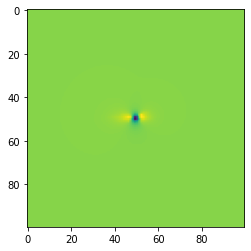

In [32]:
test = np.reshape(v1[:, max_idx], (100, 100))
plt.imshow(test)

In [15]:
theta = np.pi/4
new_coords = rotate_matrix(theta, coords)

# Find knn
print("Finding k-nearest neighbors")
k_nn, k_nn_dists = find_k_nn3(new_coords, coords, row_coords, col_coords, k)

if 0 in sel_fields:
    rot_v_pred = rotate_scalar_field(k_nn, k_nn_dists, v2)
    print("Finished v_pred")
if 1 in sel_fields or 2 in sel_fields or 3 in sel_fields:
    rot_B_pred = rotate_vector_field(k_nn, k_nn_dists, B2, theta)
    print("Finished b_pred")



Finding k-nearest neighbors
Completed:  0 %
Completed:  10 %
Completed:  20 %
Completed:  30 %
Completed:  40 %
Completed:  50 %
Completed:  60 %
Completed:  70 %
Completed:  80 %
Completed:  90 %
Finished v_pred
Finished b_pred


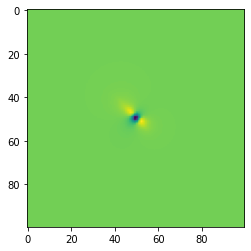

In [34]:
test = np.reshape(rot_v_pred[:, max_idx], (100, 100))
plt.imshow(test)

In [ ]:
v_corrs = np.zeros((len(thetas), 1))
b_corrs = np.zeros((len(thetas), 3, 1))

b_fields = ['Bx', 'By', 'Bz']

for n, theta in enumerate(thetas):
    
    # Get rotated coordinates
    new_coords = rotate_matrix(theta, coords)

    # Find knn
    print("Finding k-nearest neighbors")
    k_nn, k_nn_dists = find_k_nn3(new_coords, coords, row_coords, col_coords, k)

    if 0 in sel_fields:
        rot_v_pred = rotate_scalar_field(k_nn, k_nn_dists, v2)
        print("Finished v_pred")
    if 1 in sel_fields or 2 in sel_fields or 3 in sel_fields:
        rot_B_pred = rotate_vector_field(k_nn, k_nn_dists, B2, theta)
        print("Finished b_pred")
    
    print("Theta: ", theta)

    for q, trans_coord in enumerate(trans_coords):
        x_translation, y_translation = trans_coord   

        idxs_grab, idxs_place = get_grab_place_idxs(coords, col_coords, row_coords, x_translation, y_translation)        

        if 0 in sel_fields:
            
            new_v = np.zeros(np.shape(v1))

            new_v[idxs_place] = rot_v_pred[idxs_grab]

            v_corr = np.sum(new_v * v1) / (np.linalg.norm(new_v) * np.linalg.norm(v1))
            v_corrs[n, q] = v_corr
            
            print(q, trans_coord, "V Correlation: ", v_corr)

        for i in range(3):
            if (i+1) in sel_fields:
                new_B = np.zeros(np.shape(B1[:, :, i]))
                new_B[idxs_place] = rot_B_pred[idxs_grab, :, i]
                b_corr = np.sum(new_B * B1[:, :, i]) / (np.linalg.norm(new_B) * np.linalg.norm(B1[:, :, i]))
                b_corrs[n, i, q] = b_corr
                print(q, trans_coord, b_fields[i], "Correlation: ", b_corr)

print("v_corrs mean: ", np.mean(v_corrs))
print("b_corrs mean: ", np.mean(b_corrs[:, 0]), np.mean(b_corrs[:, 1]), np.mean(b_corrs[:, 2]))

save_folder = '/home/groups/adapoon/ziad/SpikeSorting/CorrelationOutput/'

save_file = 'TranslationRotationData'
for i in range(1,11):
    save_file += f'_{sys.argv[i]}'
save_file += '.npy'

with open(save_folder + save_file, 'wb') as f:
    np.save(f, v_corrs)
    np.save(f, b_corrs)